# Reinforcement learning algorithms on two environments: the Atari game **Pong** and the classic control problem **Mountain Car**.

In [ ]:
!pip install gym

In [ ]:
import gym
import copy
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from itertools import count
from collections import deque,namedtuple
import matplotlib.pyplot as plt
import cv2
cv2.ocl.setUseOpenCL(False)

# PONG

In [ ]:
!pip install gym[atari]

In [ ]:
!pip install gym[accept-rom-license]

Reference: https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

For more details, see the official documentation [here](https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html)

In [ ]:
class LazyFrames(object):
    def __init__(self, frames):
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]


class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(EpisodicLifeEnv, self).__init__(env)
        self.lives = 0
        self.was_real_done = True
        self.was_real_reset = False

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self):
        if self.was_real_done:
            obs = self.env.reset()
            self.was_real_reset = True
        else:
            obs, _, _, _ = self.env.step(0)
            self.was_real_reset = False
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env=None, noop_max=30):
        super(NoopResetEnv, self).__init__(env)
        self.noop_max = noop_max
        self.override_num_noops = None
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = np.random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(0)
            if done:
                obs = self.env.reset()
        return obs

In [ ]:
def make_env(env):
    env = EpisodicLifeEnv(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = FireResetEnv(env)
    env = WarpFrame(env)
    env = FrameStack(env, 4)
    return env

In [ ]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, n_actions=None):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(512)
        self.fc_out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = x.float() / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        return self.fc_out(x)

In [ ]:
Transition = namedtuple('Transion',('state', 'action', 'next_state', 'reward'))

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    actions = tuple((map(lambda a: torch.tensor([[a]], device=device), batch.action)))
    rewards = tuple((map(lambda r: torch.tensor([r], device=device), batch.reward)))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(actions)
    reward_batch = torch.cat(rewards)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
def get_state(obs):
    state = np.array(obs)
    state = state.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    return state.unsqueeze(0)

In [ ]:
def select_action(state):
    global steps_done
    eps = eps_end + (eps_start - eps_end)* math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if  random.random() > eps:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(4)]], device=device)

In [ ]:
def train(env, n_episodes):
    tr = []
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = select_action(state)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if not done:
                next_state = get_state(obs)
            else:
                next_state = None
            reward = torch.tensor([reward], device=device)
            memory.push(state, action.to('cpu'), next_state, reward.to('cpu'))
            state = next_state
            if steps_done > 10000:
                optimize_model()
                if steps_done % target_update == 0:
                    target_net.load_state_dict(policy_net.state_dict())
            if done:
                break
        tr.append(total_reward)
        if episode % 20 == 0:
            print('Episode: {}/{} \t Total reward: {}'.format(episode, n_episodes, total_reward))
    return tr

In [ ]:
steps_done = 0
batch_size = 32
gamma = 0.99
eps_start = 1
eps_end = 0.02
eps_decay = 1000000
target_update = 1000
MEMORY_SIZE = 100000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(n_actions=4).to(device)
target_net = DQN(n_actions=4).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(),lr = 1e-4)
memory = ReplayMemory(MEMORY_SIZE)

In [ ]:
env = gym.make("ALE/Pong-v5",render_mode='rgb_array')
env = make_env(env)
tr = train(env, 400)
torch.save(policy_net, "DQN_Pong_Model")

Episode: 0/400 	 Total reward: -21.0
Episode: 20/400 	 Total reward: -20.0
Episode: 40/400 	 Total reward: -21.0
Episode: 60/400 	 Total reward: -21.0
Episode: 80/400 	 Total reward: -21.0
Episode: 100/400 	 Total reward: -20.0
Episode: 120/400 	 Total reward: -21.0
Episode: 140/400 	 Total reward: -21.0
Episode: 160/400 	 Total reward: -21.0
Episode: 180/400 	 Total reward: -21.0
Episode: 200/400 	 Total reward: -21.0
Episode: 220/400 	 Total reward: -21.0
Episode: 240/400 	 Total reward: -18.0
Episode: 260/400 	 Total reward: -21.0
Episode: 280/400 	 Total reward: -21.0
Episode: 300/400 	 Total reward: -20.0
Episode: 320/400 	 Total reward: -21.0
Episode: 340/400 	 Total reward: -21.0
Episode: 360/400 	 Total reward: -21.0
Episode: 380/400 	 Total reward: -21.0


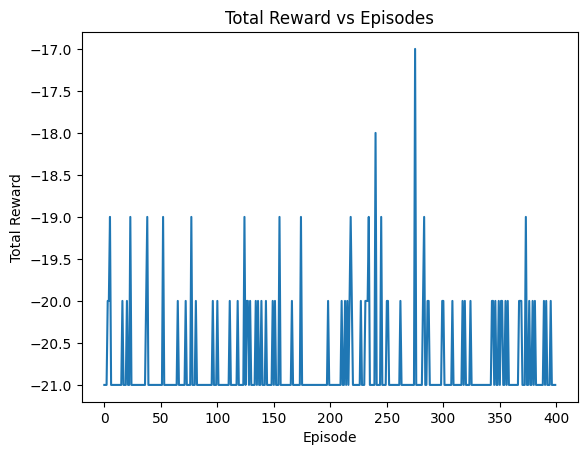

In [ ]:
plt.plot(tr)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes')
plt.show()

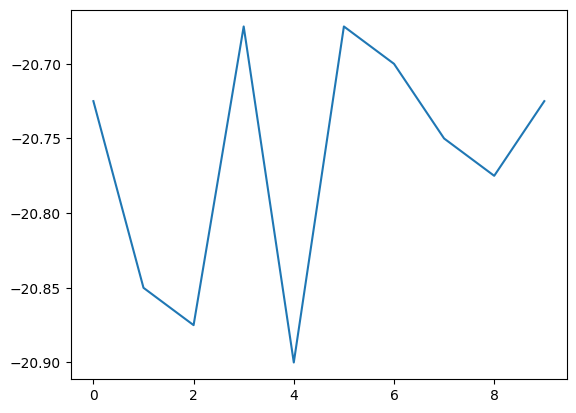

In [ ]:
mean_tr = np.mean(np.array(tr).reshape(-1, 40), axis=1)
plt.plot(mean_tr)
plt.show()

In [ ]:
success_rate = np.where(np.array(tr[-50:]) > -21, 1, 0).mean()
success_rate

0.28

In [ ]:
def test(env, n_episodes, net):
    env = gym.wrappers.RecordVideo(env, './videos/' + 'DQN_Pong')
    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)
        total_reward = 0.0
        for t in count():
            action = net(state.to(device)).max(1)[1].view(1,1)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if not done:
                next_state = get_state(obs)
            else:
                next_state = None
            state = next_state
            if done:
                print("reward {}".format(total_reward))
                break
    env.close()

In [ ]:
net = torch.load("DQN_Pong_Model")
ff = test(env, 1, net)

reward -16.0


# Mountain Car

## Value Iteration

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
def disc_states(state, env_low = env.observation_space.low , env_high =env.observation_space.high , bins = 10):
    disc_env = (env_high - env_low) / bins
    disc_pos = int((state[0] - env_low[0]) / disc_env[0])
    disc_vel = int((state[1] - env_low[1]) / disc_env[1])
    return disc_pos, disc_vel

In [ ]:
v = np.zeros((10,10))

In [ ]:
dict_states = {}
for i, (x, y) in enumerate(np.ndenumerate(v)):
    dict_states[i] = x

In [ ]:
def to_index(pos,vel):
   return list(dict_states.keys())[list(dict_states.values()).index((pos, vel))]

In [ ]:
def get_next_state_and_reward(env, state, action):
  next_state, reward, done, _ = env.step(action)
  return next_state, reward

Transition Dynamics:
Given an action, the mountain car follows the following transition dynamics:

velocityt+1 = velocityt + (action - 1) * force - cos(3 * positiont) * gravity

positiont+1 = positiont + velocityt+1

where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].

In [ ]:
def get_next_state(state, action, force=0.001, gravity=0.0025):
  action_force = action - 1
  new_velocity = state[1] + action_force * force - np.cos(3 * state[0]) * gravity
  new_velocity = np.clip(new_velocity, -0.07, 0.07)
  new_position = state[0] + new_velocity
  new_position = np.clip(new_position, -1.2, 0.6)
  if new_position <= -1.2:
    new_position = -1.2
    new_velocity = 0.0
  elif new_position >= 0.6:
    new_position = 0.6
    new_velocity = 0.0

  return new_position, new_velocity

In [ ]:
def get_q_values(env, state, prev_v, gamma=0.9):
  q_values = np.zeros(env.action_space.n)
  for a in range(env.action_space.n):
    pos, vel = state[0], state[1]
    new_pos, new_vel= get_next_state([pos,vel], a)
    next_pos, next_vel = disc_states([new_pos, new_vel])
    reward = -1
    if new_pos >= 0.5 :
      reward = +100
    index = to_index(pos,vel)
    total = reward + gamma * prev_v[index]
    q_values[a] = total
  return q_values

In [ ]:
def value_iteration(env, gamma=0.9):

  state_space_size = 10 * 10
  v = np.zeros(state_space_size)
  policy = np.zeros(state_space_size)
  max_iterations = 2000
  for i in range(max_iterations):
    prev_v = np.copy(v)
    for i in range(state_space_size):
      state = dict_states [i]
      q_values = get_q_values(env, state, prev_v, gamma)
      v[i] = np.max(q_values)
  return v

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
V = value_iteration(env)

In [ ]:
def test_policy(env, V):
  total_reward = 0
  state = env.reset()
  while True:
    state_disc= disc_states(state)
    state_index = to_index(state_disc[0],state_disc[1])
    q = get_q_values(env, state_disc, V, gamma=0.9)
    action = np.argmax(q)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state
    if done:
      break
  return total_reward

In [ ]:
r = test_policy(env, V)
r

-200.0

## Q learning

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
def disc_states(state, env_low = env.observation_space.low , env_high =env.observation_space.high , bins = 10):
    disc_env = (env_high - env_low) / bins
    disc_pos = int((state[0] - env_low[0]) / disc_env[0])
    disc_vel = int((state[1] - env_low[1]) / disc_env[1])
    return disc_pos, disc_vel

In [ ]:
def Q_Learning(print_ = False):
  Q = np.zeros((10, 10, env.action_space.n))
  eps_rewards = []
  num_eps = 2000
  alpha_init = alpha = 0.1
  gamma = 0.9
  epsilon_init = epsilon = 1
  for ep in range(num_eps):
      state = env.reset()
      reward_sum = 0
      done = False
      pos, vel = disc_states(state)
      while not done:
          if random.random() < epsilon:
              action = env.action_space.sample()
          else:
              action = np.argmax(Q[pos][vel])
          next_state, reward, done, info = env.step(action)
          next_pos, next_vel = disc_states(next_state)
          if done and next_state[0] >= env.goal_position:
              Q[next_pos][next_vel][action] = 100
          else:
              Q[pos][vel][action] += alpha * (reward + gamma * np.max(Q[next_pos][next_vel]) - Q[pos][vel][action])

          state = next_state
          pos, vel = next_pos, next_vel
          reward_sum += reward
      epsilon = epsilon_init * np.exp(-1. * ep / 100)
      alpha = alpha_init * np.exp(-1. * ep / 1000)
      eps_rewards.append(reward_sum)
      if print_:
         if ep % 100 == 0:
            print('Episode: {}  ,  epsilon: {} , reward:  {}'.format(ep, epsilon, reward_sum))
  return Q, eps_rewards

In [ ]:
Q, reward_ep = Q_Learning(print_=True)

Episode: 0  ,  epsilon: 1.0 , reward:  -200.0
Episode: 100  ,  epsilon: 0.36787944117144233 , reward:  -200.0
Episode: 200  ,  epsilon: 0.1353352832366127 , reward:  -200.0
Episode: 300  ,  epsilon: 0.049787068367863944 , reward:  -200.0
Episode: 400  ,  epsilon: 0.01831563888873418 , reward:  -200.0
Episode: 500  ,  epsilon: 0.006737946999085467 , reward:  -132.0
Episode: 600  ,  epsilon: 0.0024787521766663585 , reward:  -178.0
Episode: 700  ,  epsilon: 0.0009118819655545162 , reward:  -164.0
Episode: 800  ,  epsilon: 0.00033546262790251185 , reward:  -146.0
Episode: 900  ,  epsilon: 0.00012340980408667956 , reward:  -178.0
Episode: 1000  ,  epsilon: 4.5399929762484854e-05 , reward:  -200.0
Episode: 1100  ,  epsilon: 1.670170079024566e-05 , reward:  -145.0
Episode: 1200  ,  epsilon: 6.14421235332821e-06 , reward:  -149.0
Episode: 1300  ,  epsilon: 2.2603294069810542e-06 , reward:  -151.0
Episode: 1400  ,  epsilon: 8.315287191035679e-07 , reward:  -185.0
Episode: 1500  ,  epsilon: 3.05

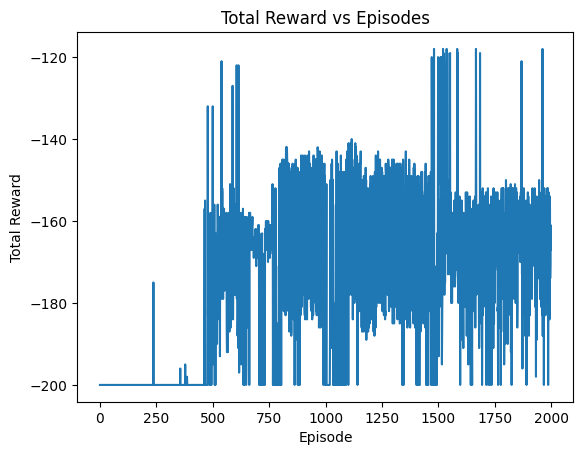

In [ ]:
plt.plot(reward_ep)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes')
plt.show()

In [ ]:
rewards = []
best_reward = -200
Q_star = np.zeros((10, 10, env.action_space.n))
for _ in range(20):
    q, reward = Q_Learning()
    avg_reward = np.mean(reward)
    rewards.append(avg_reward)
    if avg_reward > best_reward :
      Q_star = q
      best_reward = avg_reward

average rewards over 20 times of training :  -179.25385
best reward :  -168.1225


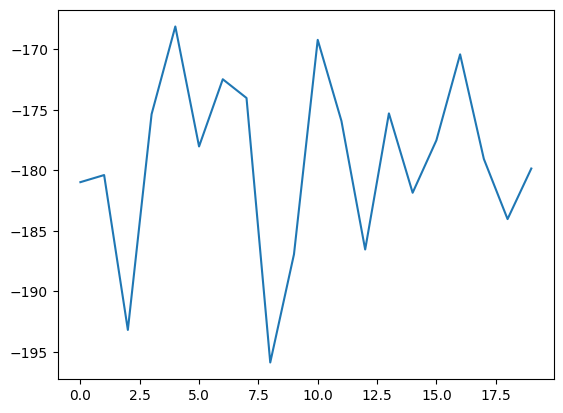

In [ ]:
print('average rewards over 20 times of training : ',np.mean(rewards))
print('best reward : ',best_reward)
plt.plot(rewards)
plt.show()

In [ ]:
# test
env = gym.make('MountainCar-v0')
env = gym.wrappers.RecordVideo(env, './videos/' + 'Q_learning mountain car')
state = env.reset()
done = False
while not done :
  pos, vel = disc_states(state)
  action = np.argmax(Q_star[pos][vel])
  next_state , reward , done , info = env.step(action)
  state = next_state
env.close()

## SARSA

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
def SARSA(print_ = False):
  Q = np.zeros((10, 10, env.action_space.n))
  eps_rewards = []
  num_eps = 2000
  alpha_init = alpha = 0.1
  gamma = 0.9
  epsilon_init = epsilon = 1
  for ep in range(num_eps):
      reward_sum = 0
      done = False
      state = env.reset()
      pos, vel = disc_states(state)
      if random.random() < epsilon:
         action = env.action_space.sample()
      else:
         action = np.argmax(Q[pos][vel])
      while not done:
          next_state, reward, done, info = env.step(action)
          next_pos, next_vel = disc_states(next_state)
          if random.random() < epsilon:
              next_action = env.action_space.sample()
          else:
              next_action = np.argmax(Q[pos][vel])
          if done and next_state[0] >= env.goal_position:
              Q[next_pos][next_vel][action] = 100
          else:
              Q[pos][vel][action] += alpha * (reward + gamma * Q[next_pos][next_vel][next_action] - Q[pos][vel][action])
          state = next_state
          pos, vel = next_pos, next_vel
          action = next_action
          reward_sum += reward
      epsilon = epsilon_init * np.exp(-1. * ep / 100)
      alpha = alpha_init * np.exp(-1. * ep / 1000)
      eps_rewards.append(reward_sum)
      if print_:
         if ep % 20 == 0:
            print('Episode: {}  ,  epsilon: {} , reward:  {}'.format(ep, epsilon, reward_sum))
  return Q, eps_rewards

In [ ]:
Q, reward_ep = SARSA(print_=True)

Episode: 0  ,  epsilon: 1.0 , reward:  -200.0
Episode: 20  ,  epsilon: 0.8187307530779818 , reward:  -200.0
Episode: 40  ,  epsilon: 0.6703200460356393 , reward:  -200.0
Episode: 60  ,  epsilon: 0.5488116360940264 , reward:  -200.0
Episode: 80  ,  epsilon: 0.44932896411722156 , reward:  -200.0
Episode: 100  ,  epsilon: 0.36787944117144233 , reward:  -200.0
Episode: 120  ,  epsilon: 0.30119421191220214 , reward:  -200.0
Episode: 140  ,  epsilon: 0.2465969639416065 , reward:  -200.0
Episode: 160  ,  epsilon: 0.20189651799465538 , reward:  -200.0
Episode: 180  ,  epsilon: 0.16529888822158653 , reward:  -200.0
Episode: 200  ,  epsilon: 0.1353352832366127 , reward:  -200.0
Episode: 220  ,  epsilon: 0.11080315836233387 , reward:  -200.0
Episode: 240  ,  epsilon: 0.09071795328941251 , reward:  -200.0
Episode: 260  ,  epsilon: 0.07427357821433388 , reward:  -200.0
Episode: 280  ,  epsilon: 0.06081006262521797 , reward:  -200.0
Episode: 300  ,  epsilon: 0.049787068367863944 , reward:  -200.0
Ep

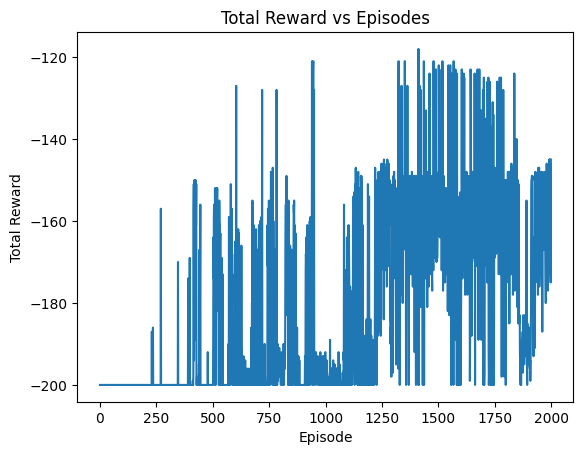

In [ ]:
plt.plot(reward_ep)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes')
plt.show()

In [ ]:
rewards = []
best_reward = -200
Q_star = np.zeros((10, 10, env.action_space.n))
for _ in range(20):
    q, reward = SARSA()
    avg_reward = np.mean(reward)
    rewards.append(avg_reward)
    if avg_reward > best_reward :
      Q_star = q
      best_reward = avg_reward

average rewards over 20 times of training :  -177.4625
best reward :  -173.6525


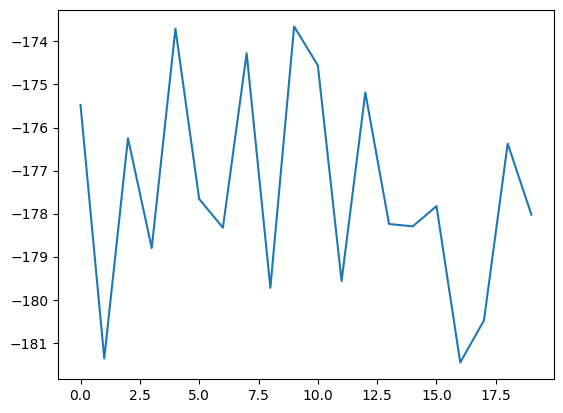

In [ ]:
print('average rewards over 20 times of training : ',np.mean(rewards))
print('best reward : ',best_reward)
plt.plot(rewards)
plt.show()

In [ ]:
# test
env = gym.make('MountainCar-v0')
env = gym.wrappers.RecordVideo(env, './videos/' + 'SARSA mountain car')
state = env.reset()
done = False
while not done :
  pos, vel = disc_states(state)
  action = np.argmax(Q_star[pos][vel])
  next_state , reward , done , info = env.step(action)
  state = next_state
env.close()